# COVID-19 Data Analyzed Through the Lens of the SIR-model

Consider the SIR model:
$$\begin{align*}
\frac{dS}{dt}&=-aS(\frac{I}{N})\\
\frac{dI}{dt}&=aS(\frac{I}{N})-bI\\
\frac{dR}{dt}&=bI
\end{align*}
$$
Our goal for this project is to analyze COVID-19 data from 15 different regions, fit a curve through parameter estimation, and interpret our results. 

The regions we will be analyzing will include 15 US states. For a more complete picture under the SIR model, I will likely choose regions that are labeled with a data-quality grade of B or higher. These are the states that have the most complete data reporting, and thus the model we create will likely be more reliable.

The primary goal of this project is to estimate the parameters of the SIR-model using some parameter estimation method (in our case, we will be using the Gauss-Newton Algorithm) based on the data we are given. From here, we will use standard methods to solve the system above. 

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import math as m
from scipy.integrate import odeint
import scipy.optimize

In [2]:
# The commands below extract just the cummulative number of positive cases

url = 'https://covidtracking.com/api/v1/states/daily.csv'   

states = pd.read_csv(url,
                     usecols=['date', 'state', 'positive'], # grab only these columns from CSV
                     parse_dates=['date'],                  # .. confusing 
                     index_col=['state', 'date'],           # use these as column labels
                     squeeze=True).sort_index()             # sort the data 

states2 = pd.read_csv(url,
                     usecols=['date', 'state', 'recovered', 'death'], # grab only these columns from CSV
                     parse_dates=['date'],                  # .. confusing 
                     index_col=['state', 'date'],           # use these as column labels
                     squeeze=True).sort_index()             # sort the data

A natural start to our project is to first find the data we'd actually like to analyze. As a example, we will start with where the pandemic started: Hubei. From there, we will utilize the same methods to obtain out results of the 14 other regions.

### Hubei (Wuhan)

In [3]:
url2 = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
url3 = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv"
url4 = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv"
# url2: cases, url3: recovered, url4: dead
arr = [0];
for i in range(4, 118):
    arr.append(i);
case_file = pd.read_csv(url2, usecols = arr, squeeze = True).sort_index();
recov_file = pd.read_csv(url3, usecols = arr, squeeze = True).sort_index(); #53
dead_file = pd.read_csv(url4, usecols = arr, squeeze = True).sort_index(); #62

arr = arr[1:];
case_file = pd.read_csv(url2, usecols = arr, squeeze = True).sort_index();
recov_file = pd.read_csv(url3, usecols = arr, squeeze = True).sort_index();
dead_file = pd.read_csv(url4, usecols = arr, squeeze = True).sort_index();

new_cases = np.array(case_file.loc[62].diff().fillna(0));
new_recov = np.array(recov_file.loc[53].diff().fillna(0));
new_dead = np.array(dead_file.loc[62].diff().fillna(0));

all_dead = np.array(dead_file.loc[62].fillna(0));
all_recov = np.array(recov_file.loc[62].fillna(0));

In [5]:
N = (58.5)*(10**6); #we will take the total population of the province as being N and assume that it is constant
s_t = [];
temp = N;
for i in range(new_cases.size):
    s_t.append(temp-new_cases[i]);
    temp-=new_cases[i];
    
i_t = [];
temp2 = 0;
for i in range(new_cases.size):
    temp2+=new_cases[i]-(new_recov[i]+new_dead[i]);
    i_t.append(temp2);

r_t = [];
for i in range(new_cases.size):
    r_t.append(all_recov[i]+all_dead[i]);

for i in range(len(s_t)):
    if i_t[i] != 0:
        I0 = i_t[i];
        s_t = s_t[i:];
        i_t = i_t[i:];
        r_t = r_t[i:];
        break;
        
S0 = N - I0;
R0 = N-I0-S0;
s_t = np.array(s_t);
i_t = np.array(i_t);
r_t = np.array(r_t);

t = np.linspace(0, len(s_t), len(s_t));

Let us now apply a parameter estimation method of our choice. A traditional method would be to use the Gauss-Newton Algorithm (GNA) discussed in class, and the alogrithm used can be found in the SIRmodelfit notebook. However, since Python has libraries that offer the desired functions for our purposes (albeit using differen methods), I will opt to use those. I will be using the scipy.optimize library and the curve_fit() function to extract the parameters. 

The function in question uses what is known as the __Levenberg-Marquardt alogrithm (LMA)__, which is a more robust algroithm than GNA in that a solution can still be found even if the "guess" parameters are far from the minimum. 

An LMA-update looks rather similar to that the GNA normal equation except there is a damping parameter, $\lambda$.
$$
    \begin{align*}
        (J^TJ+\lambda I)\Delta \theta = J^T[\Delta y]
    \end{align*}
$$
Notice that if $\lambda$ is small, the problem reduces to the GNA normal equation.

In [6]:
def f(X, t, a, b):
    S, I, R = X;
    return -(a/N)*I*S, ((a/N)*I*S)-(b*I), b*I;

x0 = [S0, I0, R0];

def SIR_sol(a, X0, b):
    sol = odeint(f, X0, t, args=(a, b));
    return sol;

In [9]:
def model(t, a, b):
    y_t = SIR_sol(a, np.array(x0), b);
    return y_t[:,1]; 

#params = scipy.optimize.curve_fit(model, t, i_t);
params = scipy.optimize.curve_fit(model, t, i_t, bounds=([0,0],[10,10]))

In [10]:
params[0]

array([6.07880734, 5.80367042])

In [18]:
x0

[58499905.0, 95.0, 0.0]

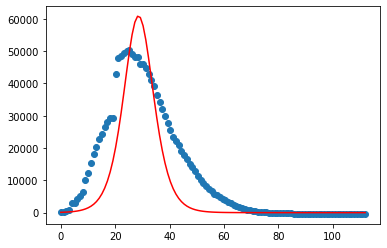

In [11]:
real_sol = SIR_sol(params[0][0], np.array(x0), params[0][1]);
plt.scatter(t, i_t);
plt.plot(t, real_sol[:,1], "r");